### Install Libs

In [1]:
!pip install rdt

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 280 kB 52.6 MB/s 
     |████████████████████████████████| 15.7 MB 46.3 MB/s 
     |████████████████████████████████| 636 kB 58.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Unin

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DATA PROCESSING

In [8]:
import pandas as pd
import numpy as np
from rdt.transformers import OneHotEncodingTransformer
from sklearn import preprocessing
import random
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
class DataProcessing():
  def __init__(self, df,disc_name,cont_name):
        super(DataProcessing, self).__init__()
        self.data=df[disc_name+cont_name]
        self.disc_colmns=disc_name
        self.cont_colmns=cont_name
  def show(self):
    print(self.data)
  def transformData(self):
    new_data=[]
    for i in range(len(self.disc_colmns)):
      ohe = OneHotEncodingTransformer()
      fit_data = pd.DataFrame(self.data, columns=[self.disc_colmns[i]])
      ohe.fit(fit_data, self.disc_colmns[i])
      num_categories = len(ohe.dummies)
      print(num_categories)
      if i==0:
        new_data=ohe.transform(fit_data).to_numpy()
      else:
        new_data=np.concatenate((new_data, ohe.transform(fit_data).to_numpy()), axis=1)
    self.transformations=[]
    for i in range(len(self.cont_colmns)):
      scaler = preprocessing.StandardScaler()
      fit_data = pd.DataFrame(self.data, columns=[self.cont_colmns[i]]).to_numpy()
      scaler.fit(fit_data)
      new_data=np.concatenate((new_data, scaler.transform(fit_data)), axis=1)
      self.transformations.append((scaler.mean_,scaler.scale_))
    print('Before Transformation: ')
    print(self.data.head(5))
    print('After Transformation: ')
    df=pd.DataFrame(new_data,columns=['Outcomes1','Outcomes2','Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigree','Age'])
    print(df.head(5))
    return new_data
  def transformBack(self,data):
    clmns=columns=['Outcomes1','Outcomes2','Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigree','Age']
    df_prev=pd.DataFrame(data,columns=clmns)
    new_datan=[]
    
    print(len(self.cont_colmns))
    for j in range(len(data)):
      new_data=[]
      new_data.append(np.argmax(data[j,0:2]))
      for i in range(len(self.cont_colmns)):
        m_,v_=self.transformations[i]
        new_data.append(np.rint(v_*data[j,1+i]+m_))
      new_datan.append(new_data)
    print('Synthesized Data (Normed): ')
    print(df_prev.head(5))
    print('Synthesized Data (De-Normed): ')
    df=pd.DataFrame(new_datan,columns=['Outcomes','Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigree','Age'])
    print(df.head(5))
def GHData():
  df=pd.read_csv('/content/drive/MyDrive/DL/diabetes.csv')
  dp=DataProcessing(df,['Outcomes'],['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigree','Age'])
  transform_data=dp.transformData()
  print('Dimension of Dataset: ', transform_data.shape)
  return transform_data,dp  

In [10]:
vv,dp=GHData()

2
Before Transformation: 
   Outcomes  Pregnancies  Glucose  ...   BMI  DiabetesPedigree  Age
0         1            6      148  ...  33.6             0.627   50
1         0            1       85  ...  26.6             0.351   31
2         1            8      183  ...  23.3             0.672   32
3         0            1       89  ...  28.1             0.167   21
4         1            0      137  ...  43.1             2.288   33

[5 rows x 9 columns]
After Transformation: 
   Outcomes1  Outcomes2  Pregnancies  ...       BMI  DiabetesPedigree       Age
0        1.0        0.0     0.639947  ...  0.204013          0.468492  1.425995
1        0.0        1.0    -0.844885  ... -0.684422         -0.365061 -0.190672
2        1.0        0.0     1.233880  ... -1.103255          0.604397 -0.105584
3        0.0        1.0    -0.844885  ... -0.494043         -0.920763 -1.041549
4        1.0        0.0    -1.141852  ...  1.409746          5.484909 -0.020496

[5 rows x 10 columns]
Dimension of Datas

In [11]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [12]:
batch_size = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5

In [13]:
device = T.device("cpu") 

#####################  Dataset ################################################

class PIMADataset(T.utils.data.Dataset):

  def __init__(self, data, n_rows=None):
    self.x_data = T.tensor(data, dtype=T.float32).to(device) 

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    return self.x_data[idx]
# Create dataset 
print("Creating PIMA Dataset ")
data,dp=GHData()
data_ds = PIMADataset(data) 
data_ldr = T.utils.data.DataLoader(data_ds, batch_size=batch_size,
    shuffle=True)

Creating PIMA Dataset 
2
Before Transformation: 
   Outcomes  Pregnancies  Glucose  ...   BMI  DiabetesPedigree  Age
0         1            6      148  ...  33.6             0.627   50
1         0            1       85  ...  26.6             0.351   31
2         1            8      183  ...  23.3             0.672   32
3         0            1       89  ...  28.1             0.167   21
4         1            0      137  ...  43.1             2.288   33

[5 rows x 9 columns]
After Transformation: 
   Outcomes1  Outcomes2  Pregnancies  ...       BMI  DiabetesPedigree       Age
0        1.0        0.0     0.639947  ...  0.204013          0.468492  1.425995
1        0.0        1.0    -0.844885  ... -0.684422         -0.365061 -0.190672
2        1.0        0.0     1.233880  ... -1.103255          0.604397 -0.105584
3        0.0        1.0    -0.844885  ... -0.494043         -0.920763 -1.041549
4        1.0        0.0    -1.141852  ...  1.409746          5.484909 -0.020496

[5 rows x 10 colu

### GeNeratOR

In [14]:
import numpy as np
import torch as T
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.input_dim = 100
    self.out_dim1 = 2
    self.out_dim2 = 8
    no=[64, 128, 64]
    self.fc1 = T.nn.Linear(self.input_dim, no[0])
    self.fc2 = T.nn.Linear(no[0], no[1])
    self.fc3 = T.nn.Linear(no[1], no[2])
    self.fc4 = T.nn.Linear(no[2], self.out_dim1)
    self.fc5 = T.nn.Linear(no[2], self.out_dim2)
  def forward(self, x):
    z = T.relu(self.fc1(x))    
    z = T.relu(self.fc2(z))    
    z = T.relu(self.fc3(z))   
    z1 = T.sigmoid(self.fc4(z))    
    z2 = self.fc5(z) 
    z = T.cat((z1,z2),1)    
    return z

In [15]:
netG = Generator()

### Discriminator

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.input_dim = 10
    no=[64, 128, 64, 10]
    self.fc1 = T.nn.Linear(self.input_dim, no[0])
    self.fc2 = T.nn.Linear(no[0], no[1])
    self.fc3 = T.nn.Linear(no[1], no[2])  
    self.fc4 = T.nn.Linear(no[2], no[3])  
    
  def forward(self, x):
    z = T.relu(self.fc1(x))    
    z = T.relu(self.fc2(z))    
    z = T.relu(self.fc3(z))   
    z = T.sigmoid(self.fc4(z))     
    return z

In [17]:
# Create the Discriminator
netD = Discriminator()

### Loss Functions and Optimizers

In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.001, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.001, betas=(beta1, 0.999))

### Training

In [19]:
# Training Loop

data_list = []  # Contain synthesized Data 
G_losses = []  # Generator Loss after eah EPOCH 
D_losses = []  # Discrminator Loss after eah EPOCH 
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_ldr, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data
        b_size = real_cpu.size(0)
        label = torch.full((b_size,10), real_label, dtype=torch.float, device=device).view(-1)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100)
        # Generate fake image batch with G
        
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output,label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_ldr),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_ldr)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            data_list.append(fake)

        iters += 1

Starting Training Loop...
[0/100][0/12]	Loss_D: 1.3874	Loss_G: 0.6657	D(x): 0.5152	D(G(z)): 0.5144 / 0.5142
[1/100][0/12]	Loss_D: 1.3004	Loss_G: 0.6772	D(x): 0.5636	D(G(z)): 0.5153 / 0.5082
[2/100][0/12]	Loss_D: 0.9362	Loss_G: 0.7882	D(x): 0.7598	D(G(z)): 0.4781 / 0.4552
[3/100][0/12]	Loss_D: 1.1281	Loss_G: 0.9911	D(x): 0.6606	D(G(z)): 0.4876 / 0.3751
[4/100][0/12]	Loss_D: 0.5725	Loss_G: 1.3383	D(x): 0.8396	D(G(z)): 0.3090 / 0.2667
[5/100][0/12]	Loss_D: 0.9721	Loss_G: 1.8236	D(x): 0.5452	D(G(z)): 0.2273 / 0.1681
[6/100][0/12]	Loss_D: 1.1250	Loss_G: 1.5350	D(x): 0.5836	D(G(z)): 0.3556 / 0.2184
[7/100][0/12]	Loss_D: 0.5939	Loss_G: 1.7979	D(x): 0.8183	D(G(z)): 0.2824 / 0.1697
[8/100][0/12]	Loss_D: 1.0976	Loss_G: 1.7011	D(x): 0.5981	D(G(z)): 0.2491 / 0.1850
[9/100][0/12]	Loss_D: 1.3692	Loss_G: 1.3649	D(x): 0.5816	D(G(z)): 0.4358 / 0.2589
[10/100][0/12]	Loss_D: 0.6378	Loss_G: 1.7908	D(x): 0.7315	D(G(z)): 0.2226 / 0.1779
[11/100][0/12]	Loss_D: 1.0674	Loss_G: 1.3394	D(x): 0.6746	D(G(z)): 0.32

### Results

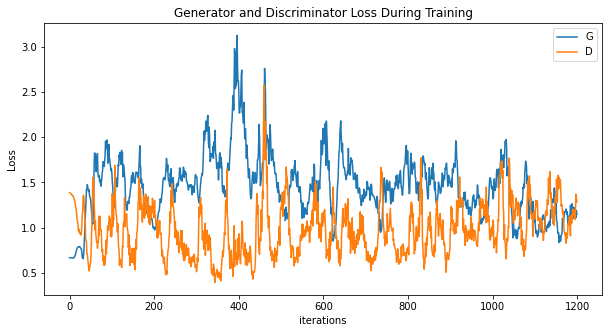

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Show Synthesized/Generated Data**

In [21]:
dp.transformBack(np.array(data_list[0]))

8
Synthesized Data (Normed): 
   Outcomes1  Outcomes2  Pregnancies  ...       BMI  DiabetesPedigree       Age
0   0.478522   0.527264    -0.067991  ...  0.119275         -0.135048  0.047332
1   0.490200   0.540165    -0.005680  ...  0.196951         -0.109635  0.022048
2   0.490978   0.543076    -0.107856  ...  0.164045         -0.090534  0.059127
3   0.498474   0.557347    -0.012689  ...  0.165514         -0.122702 -0.042001
4   0.488375   0.553935    -0.065039  ...  0.100603         -0.087465  0.050818

[5 rows x 10 columns]
Synthesized Data (De-Normed): 
   Outcomes Pregnancies  Glucose  ...     BMI DiabetesPedigree     Age
0         1       [6.0]  [119.0]  ...  [31.0]            [1.0]  [32.0]
1         1       [6.0]  [121.0]  ...  [31.0]            [1.0]  [32.0]
2         1       [6.0]  [117.0]  ...  [31.0]            [1.0]  [32.0]
3         1       [6.0]  [120.0]  ...  [31.0]            [1.0]  [32.0]
4         1       [6.0]  [119.0]  ...  [31.0]            [1.0]  [32.0]

[5 rows x